# GAN testing notebook

### Trying to use a GAN to improve Lambda PID

In [1]:
## Standard libraries
import os
import math
import time

import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim
from torch.autograd import Variable

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.optimize as opt
from scipy.stats import crystalball

#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified


# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0
Using device cuda:0


In [ ]:
from IPython.display import display, clear_output

In [4]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [14]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

#Number of graphs in each
DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [15]:
num_samples = 100
training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = num_samples, max_events = MC_max_events)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = num_samples, max_events = MC_max_events)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events)

val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [51]:
MC_Graphs = GraphDataset(prefix+MCdataset)

DATA_Graphs.graphs[0].ndata['data']

^ The above code returns the 7 data features for each particle in the 0th event
The data is then in order of these indices:\

* 0. pT
* 1. $\phi$
* 2. $\theta$
* 3. $\beta$ (velocity)
* 4. $\chi^2$
* 5. pid
* 6. status

Other kinematics can be found in the labels:
* 0. label (only for MC)
* 1. mass
* 2. Q^2
* 3. W
* 4. x
* 5. y
* 6. z
* 7. xF
DATA_Graphs.labels[:,1] <- all of the mass

GAN Input:\
Tensor(batch_size,input_size)\
Input:
1. proton pT
2. proton $\phi$
3. proton $\theta$
1. pion pT
2. pion $\phi$
3. pion $\theta$

#### Plan
1. Construct input data
    1. Tensors of pion and proton pT, theta and phi from MC
1. Make a copy of input and distort
    1. Add a random value from gaussian distribution to each proton pT
1. Train where we generate from the distorted MC as an input, MC is the truth
1. Calculate smearing matrix from output of GAN generator

In [60]:
MC_Graphs.graphs[0].ndata['data'][0]

tensor([ 0.6513,  1.2708,  0.0753,  0.0014,  0.0045, -1.0000, -0.4462],
       dtype=torch.float64)

In [62]:
m = {
    'a' : 1,
    'b' : 5
}

In [121]:
#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [128]:
class GAN_Input():
    def __init__(self, GraphDataset, num_features = 6, batch_size = 100):
        self.GraphDataset = GraphDataset
        self.num_features = num_features
        self.batch_size = batch_size
        self.num_events = len(self.GraphDataset.graphs)
        self.max_iter = int(self.num_events / self.batch_size)
        self.MC_features = torch.empty(self.num_events,self.num_features)
        self.create_data_tensor()
        self.distort()
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
        self.num_events = len(self.GraphDataset.graphs)
    def create_data_tensor(self):
        for i in range(self.num_events):
            event = self.GraphDataset.graphs[i].ndata['data']
            found_proton = False
            found_pion = False
            #loop over each particle in graph
            for j in range(event.size()[0]):
                particle = event[j]
                #catch protons
                if particle[5] == 0.8:
                    for k in range(3):
                        self.MC_features[i][k] = particle[k]
                    found_proton = True

                #catch pi-
                elif particle[5] == -0.6:
                    for k in range(3):
                        self.MC_features[i][k + 3] = particle[k]
                    found_pion = True

                #stop looking after lambda products found
                if(found_proton and found_pion):
                    break
    def distort(self,index = 0):
        #Grab random numbers
        distortions = torch.rand(self.MC_features.shape[0],self.MC_features.shape[1])
        #make distortions between -1 and 1
        distortions = (distortions * (-2)) + 1
        #Keep only numbers in the proton pT index
        distortions[:,1:] = 0
        self.distorted_features = self.MC_features + distortions
    def sample(self,iteration = 0, distorted = False):
        #0 index iterations - the "first" iteration is with iteration = 0
        # Calculate the first index we want to take from training data (rest of data is directly after)
        begin = iteration * self.batch_size
        # initialize
        samples = torch.zeros(self.batch_size, self.num_features)
        #loop over consecutive tensors, save to return tensor
        if distorted:
            for i in range(self.batch_size):
                samples[i] = self.distorted_features[begin + i]
        else:
            for i in range(self.batch_size):
                samples[i] = self.MC_features[begin + i]
        return samples

In [129]:
inputs = GAN_Input(MC_Graphs)

In [139]:
# Parameters
latent_dim = inputs.num_features
n_epochs = 50
batch_size = num_samples
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 4
channels = 1
sample_interval = 400

In [140]:
#from PyTorch-GAN github
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 160, normalize=False),
            *block(160, 80),
            *block(80, 40),
            *block(40, latent_dim)
        )

    def forward(self, z):
        out = self.model(z)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 160),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(160, 80),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(80,40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40,latent_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        validity = self.model(input)
        return validity
    

In [154]:
# Loss function
adversarial_loss = torch.nn.BCELoss()


# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [155]:

d_loss_hist = np.array([])
g_loss_hist = np.array([])
for epoch in range(n_epochs):
    d_loss_avg = 0
    g_loss_avg = 0
    clear_output(wait = True)
    display(f"Training epoch #{epoch}")
    for it in range(inputs.max_iter):
        # Adversarial ground truths
        valid = torch.ones(inputs.batch_size,latent_dim).to(device);
        fake = torch.zeros(inputs.batch_size,latent_dim).to(device);

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample DATA events as generator input
        z = inputs.sample(iteration = it, distorted = True).to(device)
        # Generate a batch of MC-like events
        gen_events = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_events), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        real_events = inputs.sample(iteration = it).to(device)
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_events), valid)
        fake_loss = adversarial_loss(discriminator(gen_events.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        d_loss_avg += d_loss.item()
        g_loss_avg += g_loss.item()
    d_loss_hist = np.append(d_loss_hist, d_loss_avg / inputs.max_iter)
    g_loss_hist = np.append(g_loss_hist, g_loss_avg / inputs.max_iter)
#         print(
#             "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
#             % (epoch, n_epochs, d_loss.item(), g_loss.item()))

'Training epoch #49'

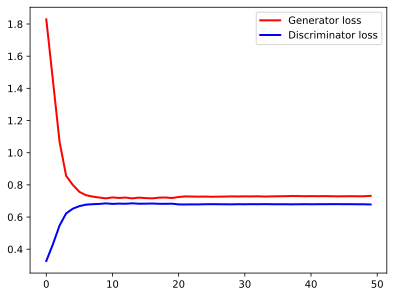

In [156]:
plt.plot(g_loss_hist,c='r',label = "Generator loss")
plt.plot(d_loss_hist,c='b',label = "Discriminator loss")
plt.legend()
plt.show()